In [45]:
%matplotlib inline

In [46]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import torch.optim as optim
import time
import datetime

In [47]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [48]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

LR = 1e-3
LR_RPROP = 1
BETAS = (0.9, 0.99)
MOMENTUM = 0.99
EPS = 1e-4
WD = 1e-4
EPOCHS = 20
BATCH_SIZE = 100
SPLIT = 10
WORKERS = 2
PATH = './cifar_net_.pth'

In [49]:
transform = transforms.Compose([transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      transforms.RandomCrop(32, padding=4),
                                      transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) #Normalize all the images
                               ])

In [50]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_len = len(trainset)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=WORKERS)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

test_len = len(testset)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=WORKERS)

Files already downloaded and verified
Files already downloaded and verified


In [51]:
print(f'train_len: {train_len}, test_len: {test_len}')

train_len: 50000, test_len: 10000


(100, 3, 32, 32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

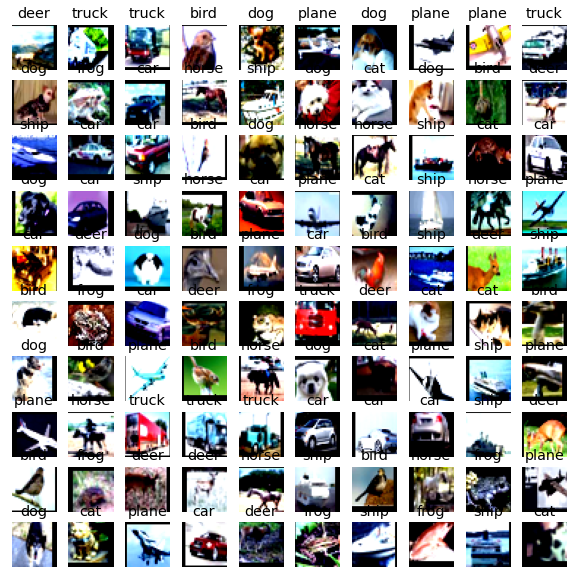

In [52]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Converting images to numpy arrays to plot
images = images.numpy()

fig = plt.figure(figsize=(BATCH_SIZE/SPLIT,SPLIT))

print(images.shape)

for index in np.arange(BATCH_SIZE):
    ax = fig.add_subplot(BATCH_SIZE/SPLIT,SPLIT,index+1,xticks=[], yticks=[])
    imshow(images[index])
    ax.set_title(classes[labels[index]])


In [53]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_layer = nn.Sequential(

            # Conv Layer 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Fully Connected Layers
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x

In [54]:
net = Net().to(device)
net

Net(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout2d(p=0.05, inplace=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [55]:
criterion = nn.CrossEntropyLoss()

In [56]:
state_dictionaries = {}
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

def train(opt):
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    print('Starting to train with optimizer: ', type(opt).__name__)
    start = time.time()
    for epoch in range(EPOCHS):  # loop over the dataset multiple times
        running_loss = 0.0
        running_corrects = 0.0
        val_running_loss = 0.0
        val_running_corrects = 0.0
        for inputs, labels in trainloader:
            inputs = inputs.to(device) # input to device as our model is running in mentioned device.
            labels = labels.to(device)
            # Forward Pass
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()

            def closure():
              return loss

            # Backward Pass and optimize
            opt.step(closure)

            _, preds = torch.max(outputs, 1)

            # print statistics
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)
            end = time.time()
        else:
          with torch.no_grad(): # we do not need gradient for validation.
            for val_inputs, val_labels in testloader:
              val_inputs = val_inputs.to(device)
              val_labels = val_labels.to(device)
              val_outputs = net(val_inputs)
              val_loss = criterion(val_outputs, val_labels)
              
              _, val_preds = torch.max(val_outputs, 1)
              val_running_loss += val_loss.item()
              val_running_corrects += torch.sum(val_preds == val_labels.data)
              c = (val_preds == val_labels).squeeze()
              for i in range(BATCH_SIZE):
                label = val_labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            
          epoch_loss = running_loss/len(trainloader) # loss per epoch
          epoch_acc = running_corrects.float()/ len(trainloader) # accuracy per epoch
          running_loss_history.append(epoch_loss) # appending for displaying 
          running_corrects_history.append(epoch_acc)
          
          val_epoch_loss = val_running_loss/len(testloader)
          val_epoch_acc = val_running_corrects.float()/ len(testloader)
          val_running_loss_history.append(val_epoch_loss)
          val_running_corrects_history.append(val_epoch_acc)
          print('epoch :', (epoch+1))
          print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
          print('validation loss: {:.4f}, validation acc {:.4f} Time: {:.4f} seconds'.format(val_epoch_loss, val_epoch_acc.item(), end - start))
    print('Finished Training with optimizer: ', type(opt).__name__)
    print(f'Average Execution time: {str(datetime.timedelta(seconds=(end - start)/EPOCHS))} (HH:MM:SS)')
    print(f'Total Execution time: {str(datetime.timedelta(seconds=end - start))} (HH:MM:SS)')
    print('Final Training Acuracy: {:.4f}%'.format(epoch_acc.item()))
    print('Final Validation Acuracy: {:.4f}%'.format(val_epoch_acc.item()))

    for i in range(len(classes)):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

    plt.style.use('ggplot')
    plt.plot(running_loss_history, label='training loss')
    plt.plot(val_running_loss_history, label='validation loss')
    plt.legend()
    plt.title("Training vs Validation Loss for " + type(opt).__name__ + " Optimiser")
    state_dictionaries[type(opt).__name__] = net.state_dict()

In [57]:
optimizers = []

Starting to train with optimizer:  SGD
epoch : 1
training loss: 1.7978, acc 32.1280 
validation loss: 1.4480, validation acc 45.9400 Time: 18.2560 seconds
epoch : 2
training loss: 1.2844, acc 52.7440 
validation loss: 1.1307, validation acc 59.0700 Time: 40.1400 seconds
epoch : 3
training loss: 0.9878, acc 64.4140 
validation loss: 0.9223, validation acc 66.8600 Time: 62.0410 seconds
epoch : 4
training loss: 0.8064, acc 71.2560 
validation loss: 0.7692, validation acc 73.1700 Time: 84.1131 seconds
epoch : 5
training loss: 0.7037, acc 75.3360 
validation loss: 0.6986, validation acc 75.7000 Time: 105.8336 seconds
epoch : 6
training loss: 0.6380, acc 77.6720 
validation loss: 0.6368, validation acc 77.9100 Time: 127.5838 seconds
epoch : 7
training loss: 0.5679, acc 80.3080 
validation loss: 0.5967, validation acc 79.6300 Time: 149.2408 seconds
epoch : 8
training loss: 0.5205, acc 81.7520 
validation loss: 0.5697, validation acc 80.7700 Time: 170.7910 seconds
epoch : 9
training loss: 0.48

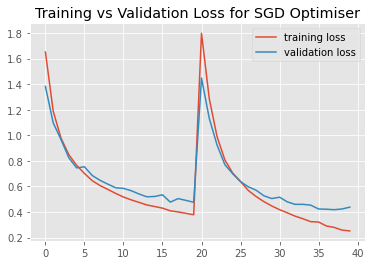

In [59]:
# Training with SGD Optimizer
net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM)

train(optimizer)
optimizers.append(optimizer)

Starting to train with optimizer:  Adam
epoch : 1
training loss: 1.6503, acc 37.3500 
validation loss: 1.3815, validation acc 49.2800 Time: 18.9748 seconds
epoch : 2
training loss: 1.1878, acc 56.7680 
validation loss: 1.0964, validation acc 59.6300 Time: 41.2319 seconds
epoch : 3
training loss: 0.9768, acc 65.5080 
validation loss: 0.9660, validation acc 65.5000 Time: 63.5638 seconds
epoch : 4
training loss: 0.8476, acc 70.2600 
validation loss: 0.8234, validation acc 71.5000 Time: 85.5130 seconds
epoch : 5
training loss: 0.7646, acc 73.1360 
validation loss: 0.7444, validation acc 74.4300 Time: 108.0187 seconds
epoch : 6
training loss: 0.7009, acc 75.7600 
validation loss: 0.7532, validation acc 74.2300 Time: 130.4294 seconds
epoch : 7
training loss: 0.6445, acc 77.5720 
validation loss: 0.6849, validation acc 76.5700 Time: 153.3350 seconds
epoch : 8
training loss: 0.6064, acc 79.1080 
validation loss: 0.6473, validation acc 78.3100 Time: 175.6609 seconds
epoch : 9
training loss: 0.5

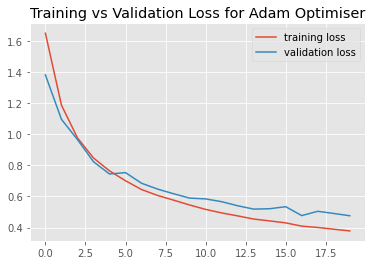

In [58]:
# Training with Adam Optimizer
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=LR, betas=BETAS, weight_decay=WD)
train(optimizer)
optimizers.append(optimizer)

Starting to train with optimizer:  Adagrad
epoch : 1
training loss: 1.4818, acc 44.7700 
validation loss: 1.2977, validation acc 51.9100 Time: 18.8437 seconds
epoch : 2
training loss: 1.1612, acc 57.8260 
validation loss: 1.0808, validation acc 60.6700 Time: 40.9696 seconds
epoch : 3
training loss: 1.0217, acc 63.1900 
validation loss: 0.9839, validation acc 65.2700 Time: 63.1111 seconds
epoch : 4
training loss: 0.9342, acc 66.4680 
validation loss: 0.9235, validation acc 67.5500 Time: 85.3398 seconds
epoch : 5
training loss: 0.8770, acc 68.8300 
validation loss: 0.8883, validation acc 68.5600 Time: 107.4592 seconds
epoch : 6
training loss: 0.8338, acc 70.4080 
validation loss: 0.8521, validation acc 69.7400 Time: 129.4317 seconds
epoch : 7
training loss: 0.7972, acc 71.8440 
validation loss: 0.8072, validation acc 71.5500 Time: 151.6762 seconds
epoch : 8
training loss: 0.7651, acc 72.9400 
validation loss: 0.8021, validation acc 71.4100 Time: 173.6943 seconds
epoch : 9
training loss: 

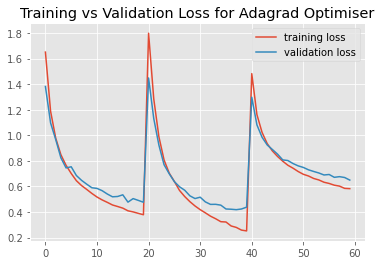

In [60]:
# Training with Adgrad Optimizer
net = Net().to(device)
optimizer = optim.Adagrad(net.parameters(), lr=LR, weight_decay=0, initial_accumulator_value=0, eps=EPS)
train(optimizer)
optimizers.append(optimizer)

Starting to train with optimizer:  Adamax
epoch : 1
training loss: 1.5041, acc 43.9860 
validation loss: 1.1841, validation acc 56.2900 Time: 18.9954 seconds
epoch : 2
training loss: 1.0420, acc 62.6800 
validation loss: 0.9409, validation acc 66.7600 Time: 41.9183 seconds
epoch : 3
training loss: 0.8452, acc 70.0540 
validation loss: 0.8449, validation acc 70.1100 Time: 65.2208 seconds
epoch : 4
training loss: 0.7377, acc 74.0160 
validation loss: 0.7115, validation acc 74.9300 Time: 88.1074 seconds
epoch : 5
training loss: 0.6556, acc 77.0980 
validation loss: 0.6457, validation acc 77.4800 Time: 110.9577 seconds
epoch : 6
training loss: 0.5918, acc 79.4080 
validation loss: 0.6322, validation acc 78.2000 Time: 133.7379 seconds
epoch : 7
training loss: 0.5450, acc 80.9800 
validation loss: 0.5777, validation acc 80.1900 Time: 156.7418 seconds
epoch : 8
training loss: 0.5092, acc 82.3820 
validation loss: 0.5501, validation acc 81.5700 Time: 179.6840 seconds
epoch : 9
training loss: 0

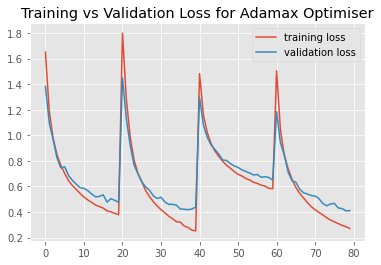

In [61]:
# Training with Adamax Optimizer
net = Net().to(device)
optimizer = optim.Adamax(net.parameters(), lr=LR) 
train(optimizer)
optimizers.append(optimizer)

Starting to train with optimizer:  ASGD
epoch : 1
training loss: 2.2966, acc 13.0800 
validation loss: 2.2885, validation acc 14.5600 Time: 18.4322 seconds
epoch : 2
training loss: 2.2747, acc 17.5580 
validation loss: 2.2532, validation acc 21.2800 Time: 40.1863 seconds
epoch : 3
training loss: 2.2092, acc 23.4840 
validation loss: 2.1482, validation acc 24.0700 Time: 62.4634 seconds
epoch : 4
training loss: 2.0779, acc 25.0320 
validation loss: 2.0081, validation acc 27.5300 Time: 84.4632 seconds
epoch : 5
training loss: 1.9513, acc 28.5540 
validation loss: 1.8902, validation acc 30.2400 Time: 106.4539 seconds
epoch : 6
training loss: 1.8475, acc 30.7340 
validation loss: 1.7921, validation acc 33.3700 Time: 128.4647 seconds
epoch : 7
training loss: 1.7654, acc 33.0880 
validation loss: 1.7212, validation acc 34.9200 Time: 150.5809 seconds
epoch : 8
training loss: 1.7039, acc 35.3240 
validation loss: 1.6701, validation acc 36.8500 Time: 172.2495 seconds
epoch : 9
training loss: 1.6

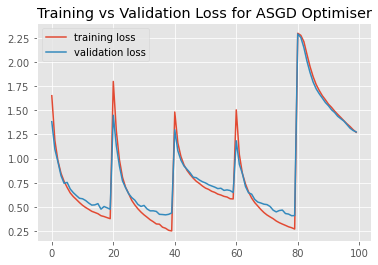

In [62]:
# Training with ASGD Optimizer
net = Net().to(device)
optimizer = optim.ASGD(net.parameters(), lr=LR)
train(optimizer)
optimizers.append(optimizer)

Starting to train with optimizer:  LBFGS
epoch : 1
training loss: 1.8419, acc 32.0340 
validation loss: 1.5865, validation acc 40.2300 Time: 23.0639 seconds
epoch : 2
training loss: 1.9673, acc 39.9620 
validation loss: 1.4619, validation acc 45.1100 Time: 49.8173 seconds
epoch : 3
training loss: 665.5124, acc 43.3140 
validation loss: 1.4315, validation acc 46.7700 Time: 77.0922 seconds
epoch : 4
training loss: 1.4490, acc 47.3800 
validation loss: 1.3059, validation acc 51.7200 Time: 104.1033 seconds
epoch : 5
training loss: 1.4152, acc 50.4800 
validation loss: 1.2545, validation acc 54.3500 Time: 131.1615 seconds
epoch : 6
training loss: 1.2883, acc 54.0220 
validation loss: 1.1917, validation acc 56.4700 Time: 158.2060 seconds
epoch : 7
training loss: 2480290463221.1206, acc 55.2680 
validation loss: 1.1269, validation acc 59.4000 Time: 185.3537 seconds
epoch : 8
training loss: 1.2284, acc 58.1580 
validation loss: 1.2107, validation acc 54.7100 Time: 212.1529 seconds
epoch : 9
tr

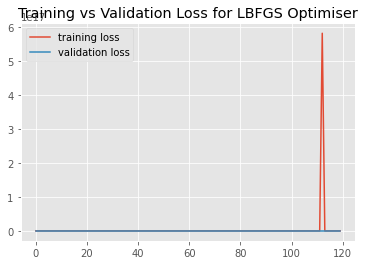

In [63]:
# Training with LBFGS Optimizer
net = Net().to(device)
optimizer = optim.LBFGS(net.parameters(), history_size=10, max_iter=4)
# torch.autograd.set_detect_anomaly(True)
train(optimizer)
optimizers.append(optimizer)

Starting to train with optimizer:  Rprop
epoch : 1
training loss: 30535641.0067, acc 9.7940 
validation loss: 428.4819, validation acc 9.9000 Time: 24.7232 seconds
epoch : 2
training loss: 427.2778, acc 10.1640 
validation loss: 435.2205, validation acc 9.5400 Time: 52.3307 seconds
epoch : 3
training loss: 424.7866, acc 10.1520 
validation loss: 428.6369, validation acc 9.7300 Time: 80.2971 seconds
epoch : 4
training loss: 425.1666, acc 9.9900 
validation loss: 415.1029, validation acc 9.6900 Time: 108.4204 seconds
epoch : 5
training loss: 423.7272, acc 9.9360 
validation loss: 426.7895, validation acc 9.9500 Time: 136.0042 seconds
epoch : 6
training loss: 424.6664, acc 10.1340 
validation loss: 424.4154, validation acc 10.3400 Time: 163.8654 seconds
epoch : 7
training loss: 424.9527, acc 9.9940 
validation loss: 422.6511, validation acc 10.3000 Time: 191.9101 seconds
epoch : 8
training loss: 424.4701, acc 10.1260 
validation loss: 425.0371, validation acc 10.1700 Time: 219.5193 second

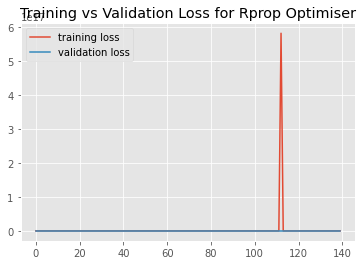

In [64]:
# Training with Rprop Optimizer
net = Net().to(device)
optimizer = optim.Rprop(net.parameters(), lr=LR_RPROP)
train(optimizer)
optimizers.append(optimizer)

In [ ]:
len(state_dictionaries)

In [67]:
def getOptimizerStateValues(opt, dict):
    return dict[type(opt).__name__]

def getOptimizerKey(opt):
    return type(opt).__name__

torch.save({
    getOptimizerKey(optimizers[0]): getOptimizerStateValues(optimizers[0], state_dictionaries),
    getOptimizerKey(optimizers[1]): getOptimizerStateValues(optimizers[1], state_dictionaries),
    getOptimizerKey(optimizers[2]): getOptimizerStateValues(optimizers[2], state_dictionaries),
    getOptimizerKey(optimizers[3]): getOptimizerStateValues(optimizers[3], state_dictionaries),
    getOptimizerKey(optimizers[4]): getOptimizerStateValues(optimizers[4], state_dictionaries),
    getOptimizerKey(optimizers[5]): getOptimizerStateValues(optimizers[5], state_dictionaries),
    getOptimizerKey(optimizers[6]): getOptimizerStateValues(optimizers[6], state_dictionaries)
}, PATH)